In [3]:
get_ipython().magic('reset -sf')

# Exploratory Analysis

In [49]:
import pandas as pd
import numpy as np
import sklearn as sk
import torch as tc
import matplotlib.pyplot as plt
from scipy.stats import kde
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from light_famd import FAMD
from sklearn import preprocessing
import category_encoders as ce
from bioinfokit.visuz import cluster
import threading
import json
import datetime

In [2]:
originaldata = pd.read_csv('../Data/Venta_Consumidor_Producto_UPC_PrevVTA_2018-2020.csv')
originaldata.shape

C:\Users\cul_g\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1327383, 46)

In [3]:
# Drop columns
dataset = originaldata.drop(columns=['ANO_MES_FACTURA', 'CANAL_VENTA_DESC', 'TEMPORADA_COMERCIAL_DESC', 'MATERIAL_ID', 'ESFUERZO_VENTA_DESC', 'NUMERO_DEUDOR', 'NUMERO_DEUDOR_PAIS_DESC', 'CONCEPTO', 'LINEA',  'PAIS_CONTACTO', 'PAIS_CONTACTO_DESC'])
# Columns I have
dataset.columns

Index(['FACTURA_ID', 'FACTURA_POSICION_ID', 'CUSTOMER_ID',
       'FACTURA_CLASE_DOCUMENTO_ID', 'ANO_FACTURA', 'MES_FACTURA',
       'FECHA_FACTURA', 'IMP_VENTA_NETO_EUR', 'CANAL_VENTA_ID',
       'TEMPORADA_COMERCIAL_ID', 'PRODUCTO_ID', 'TALLA', 'ESFUERZO_VENTA_ID',
       'NUMERO_DEUDOR_PAIS_ID', 'VENTA_DEVOLUCION', 'JERARQUIA_PROD_ID',
       'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO', 'GENERO_PRODUCTO',
       'CATEGORIA', 'TIPOLOGIA', 'COLOR', 'CONSUMER_COLOR', 'CREMALLERA',
       'CORDONES', 'OUTSOLE_SUELA_TIPO', 'OUTSOLE_SUELA_SUBTIPO',
       'PLANTILLA_EXTRAIBLE', 'CONTACTO_SN', 'EDAD_SN', 'GENERO_CONTACTO',
       'EDAD_COMPRA', 'EDAD_RANGO_COMPRA', 'CIUDAD_CONTACTO',
       'IDIOMA_CONTACTO'],
      dtype='object')

## Missing data

First of all, I am going to see if there are missing data. In the file called Estructura Datos, it says that I used CANAL_VENTA_ID  = 20 because it will be the only one, that's not true, because there are more IDs, by the moment I only use 20 but it would be nice to know which one I should use.

In [4]:
dataset_missing_data = dataset[dataset.CANAL_VENTA_ID == 20]
md = pd.DataFrame(dataset_missing_data.isnull().sum(), columns=['Number'])
md['Percentage'] = dataset_missing_data.isnull().sum()/originaldata.shape[0]*100
print(md)

                            Number  Percentage
FACTURA_ID                       0    0.000000
FACTURA_POSICION_ID              0    0.000000
CUSTOMER_ID                   1939    0.146077
FACTURA_CLASE_DOCUMENTO_ID       0    0.000000
ANO_FACTURA                      0    0.000000
MES_FACTURA                      0    0.000000
FECHA_FACTURA                    0    0.000000
IMP_VENTA_NETO_EUR               0    0.000000
CANAL_VENTA_ID                   0    0.000000
TEMPORADA_COMERCIAL_ID           0    0.000000
PRODUCTO_ID                      0    0.000000
TALLA                        27983    2.108133
ESFUERZO_VENTA_ID              951    0.071645
NUMERO_DEUDOR_PAIS_ID            0    0.000000
VENTA_DEVOLUCION                 0    0.000000
JERARQUIA_PROD_ID            21423    1.613928
GRUPO_ARTICULO_PRODUCTO_ID   21423    1.613928
GRUPO_ARTICULO               21423    1.613928
GENERO_PRODUCTO              48370    3.644012
CATEGORIA                    49115    3.700138
TIPOLOGIA    

- CUSTOMER_ID: I am not interested in it, unless I could create a profile.
- IMP_VENTA_NETO_EUR: Ghost items sold, by the moment I am going to remove these rows, because they are not adding any kind of information and I cannot add NV because I will have problems when I will calculate all the stuff.
- TALLA:
    - I can remove them
    - But I think it would be better to add NV (no informado) as it is used in other columns for the same purpose
- ESFUERZO_VENTA_ID: I don't know what is that
- GENERO_PRODUCTO: the basics are Kids, Women and Men. I can treat nulls as NV (no informado) or consider it as unisex. I prefer NV but I think it is important to keep and don't remove them, they can add value information although there are nulls
- CATEGORIA: I don't think this is an important column, I think I will not use it, by the moment I let them be null
- TIPOLOGIA: I don't think either it is an important column, as before I let them be null
- CONSUMER_COLOR: Same as before, I can use COLOR instead of this
- GENERO_CONTACTO: I am not sure what this is, I can put NV by the moment
- PAIS_CONTACTO: It can be interested to see what products are the most selled in each country and compare them. If one of the others columns refered to the customer are filled, I can extract the country, if not, the best thing I can do is to put NV
- CIUDAD_CONTACTO: Same as before, in this case, for me is not that relevant
- IDIOMA_CONTACTO: Same as before

There aren't NA/nan/Na strings and NV can only be found in the specified columns in the file I said before.

Firstly, I am going to select only the data with CANAL_VENTA_ID equal to 20. Secondly, I am going to remove all the rows where IMP_VENTA_NETO_EUR is equal to null and after I am going to replace all nulls with NV (no informado).

In [5]:
dataset = dataset[(dataset.CANAL_VENTA_ID == 20)]
dataset = dataset[(dataset.IMP_VENTA_NETO_EUR.isnull() == False) | (dataset.IMP_VENTA_NETO_EUR == 0)]
dataset.fillna("NV", inplace = True)
dataset.isnull().sum()

FACTURA_ID                    0
FACTURA_POSICION_ID           0
CUSTOMER_ID                   0
FACTURA_CLASE_DOCUMENTO_ID    0
ANO_FACTURA                   0
MES_FACTURA                   0
FECHA_FACTURA                 0
IMP_VENTA_NETO_EUR            0
CANAL_VENTA_ID                0
TEMPORADA_COMERCIAL_ID        0
PRODUCTO_ID                   0
TALLA                         0
ESFUERZO_VENTA_ID             0
NUMERO_DEUDOR_PAIS_ID         0
VENTA_DEVOLUCION              0
JERARQUIA_PROD_ID             0
GRUPO_ARTICULO_PRODUCTO_ID    0
GRUPO_ARTICULO                0
GENERO_PRODUCTO               0
CATEGORIA                     0
TIPOLOGIA                     0
COLOR                         0
CONSUMER_COLOR                0
CREMALLERA                    0
CORDONES                      0
OUTSOLE_SUELA_TIPO            0
OUTSOLE_SUELA_SUBTIPO         0
PLANTILLA_EXTRAIBLE           0
CONTACTO_SN                   0
EDAD_SN                       0
GENERO_CONTACTO               0
EDAD_COM

I only consider the products from Camper. JERARQUIA_PROD_ID = '1*'.

In [6]:
indexes = []
for k, v in zip(dataset.index, dataset.JERARQUIA_PROD_ID):
    if v[0] == '1':
        indexes.append(k)
dataset = dataset[dataset.index.isin(indexes)]

## Outlier detection

Outliers could be find in the following columns (numerical, not definit):
- IMP_VENTA_NETO_EUR
- EDAD_COMPRA

Firstly, I am going to plot the infomation in quartiles and check if I can visualize possible outliers.

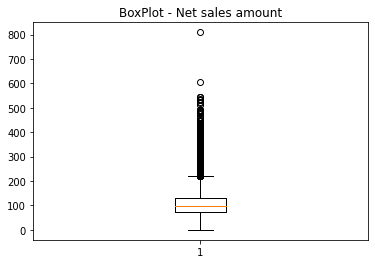

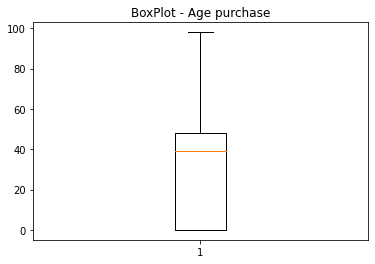

In [7]:
outlierdata = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']
# Univariate outlier detection
plt.boxplot(outlierdata['IMP_VENTA_NETO_EUR'])
plt.title('BoxPlot - Net sales amount')
plt.savefig('../Output/BoxPlotNetsalesamount.png')
plt.show()

plt.boxplot(outlierdata['EDAD_COMPRA'])
plt.title('BoxPlot - Age purchase')
plt.savefig('../Output/BoxPlotAgepurchase.png')
plt.show()

In both cases, I have found several outliers. For instance, it is not possible to sell a product with a price of 0�, or that age of the customer is less than 18 years old. Moreover, I have a lot of high prices so let's analyse all these cases.

In [8]:
highprices = outlierdata[outlierdata.IMP_VENTA_NETO_EUR >=400][['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=False).head(10)
lowprices = outlierdata[['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=True).head(10)
display(highprices)
display(lowprices)
print('Number of products cheaper than 10�: '+str(outlierdata[outlierdata.IMP_VENTA_NETO_EUR < 10].count().IMP_VENTA_NETO_EUR))

IMP_VENTA_NETO_EUR  PRODUCTO_ID         CATEGORIA  \
638256               809.45  KU00007-001                NV   
297352               603.96  K300325-003      Men Mid Boot   
679329               543.25  K300359-003    Men Ankle Boot   
677298               543.25  K400531-002  Women Ankle Boot   
679303               543.25  K400531-003  Women Ankle Boot   
1255741              534.66  K400395-002   Women High Boot   
1127325              533.00  K300310-001    Men Ankle Boot   
1098327              532.14  K300304-003    Men Ankle Boot   
1275808              525.21  K400395-002   Women High Boot   
26114                520.84  K400395-002   Women High Boot   

        NUMERO_DEUDOR_PAIS_ID   JERARQUIA_PROD_ID GRUPO_ARTICULO_PRODUCTO_ID  \
638256                     US  102BWABWA0UKU00007                        2.0   
297352                     CH  101TOGTOGKHK300325                        1.0   
679329                     JP  101WDNWDN0HK300359                        1.0   
677298                     JP  101WDNWDN0MK400531                        1.0   
679303                     JP  101WDNWDN0MK400531                        1.0   
1255741                    DE  101TOGTOGKMK400395                        1.0   
1127325                    JP  101TOGHMLWHK300310                        1.0   
1098327                    US  101TOGTOGKHK300304                        1.0   
1275808                    DE  101TOGTOGKMK400395                        1.0   
26114                      FR  101TOGTOGKMK400395                        1.0   

         GRUPO_ARTICULO  
638256             Ropa  
297352   Zapatos Adulto  
679329   Zapatos Adulto  
677298   Zapatos Adulto  
679303   Zapatos Adulto  
1255741  Zapatos Adulto  
1127325  Zapatos Adulto  
1098327     Adult Shoes  
1275808  Zapatos Adulto  
26114    Zapatos Adulto

IMP_VENTA_NETO_EUR  PRODUCTO_ID     CATEGORIA NUMERO_DEUDOR_PAIS_ID  \
562819                 0.00  K300262-001  Men Mid Boot                    DE   
955499                 0.00    L1245-001            NV                    CA   
273926                 0.00  K100356-001      Men Shoe                    FR   
654512                 0.00  KA00003-011         Socks                    ES   
956510                 0.00    L1235-001            NV                    CA   
955837                 0.00    L1245-001            NV                    CA   
491492                 0.00  K200276-003  Women Sandal                    PT   
725842                 0.46    L0037-001            NV                    BE   
120325                 0.70  K200633-005  Women Sandal                    CO   
1213457                0.70  K200633-005  Women Sandal                    CO   

          JERARQUIA_PROD_ID GRUPO_ARTICULO_PRODUCTO_ID  GRUPO_ARTICULO  
562819   101PIXPIX0HK300262                        1.0  Zapatos Adulto  
955499     104ACCACCGUL1245                        5.0    Complementos  
273926   101BILBIL0HK100356                        1.0     Adult Shoes  
654512   114SOXSOX0UKA00003                        5.0     Complements  
956510     104ACCACCGUL1235                        5.0    Complementos  
955837     104ACCACCGUL1245                        5.0    Complementos  
491492   101OGAOGASMK200276                        1.0  Zapatos Adulto  
725842     104ACCACCGUL0037                        5.0    Complementos  
120325   101OGAOGASMK200633                        1.0  Zapatos Adulto  
1213457  101OGAOGASMK200633                        1.0  Zapatos Adulto

Number of products cheaper than 10�: 9662


Looking at the table above, I have found some products that are very expensive, as my main aim of the project is to predict the shoes sold, I can remove the product which don't have the category of shoes.

Category Summarize:
- 01 -> Zapatos Adulto
- 02 -> Ropa
- 03 -> Zapatos Factorys (producto que se fabrica expresamente para Outlets)
- 04 -> Bolsos
- 05 -> Complementos (Accesorios)
- 06 -> Complementos VOR (Accesorios Volvo Ocean Race)
- 07 -> PLV
- 08 -> Kids
- 10 -> First Walkers

I am not interested in 2, 5, 6 and 7. So I am going to remove them from my dataset. Moreover, I will remove the values which have IMP_VENTA_NETO_EUR less than 10�, such that they are errors (not possible).

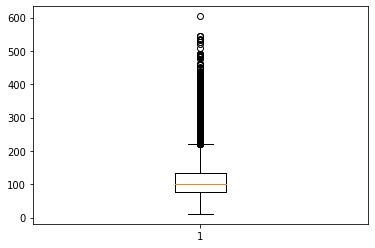

IMP_VENTA_NETO_EUR  PRODUCTO_ID         CATEGORIA  \
297352               603.96  K300325-003      Men Mid Boot   
679329               543.25  K300359-003    Men Ankle Boot   
679303               543.25  K400531-003  Women Ankle Boot   
677298               543.25  K400531-002  Women Ankle Boot   
1255741              534.66  K400395-002   Women High Boot   
1127325              533.00  K300310-001    Men Ankle Boot   
1098327              532.14  K300304-003    Men Ankle Boot   
1275808              525.21  K400395-002   Women High Boot   
26114                520.84  K400395-002   Women High Boot   
945450               509.97  K400467-003    Women Mid boot   

        NUMERO_DEUDOR_PAIS_ID   JERARQUIA_PROD_ID GRUPO_ARTICULO_PRODUCTO_ID  \
297352                     CH  101TOGTOGKHK300325                        1.0   
679329                     JP  101WDNWDN0HK300359                        1.0   
679303                     JP  101WDNWDN0MK400531                        1.0   
677298                     JP  101WDNWDN0MK400531                        1.0   
1255741                    DE  101TOGTOGKMK400395                        1.0   
1127325                    JP  101TOGHMLWHK300310                        1.0   
1098327                    US  101TOGTOGKHK300304                        1.0   
1275808                    DE  101TOGTOGKMK400395                        1.0   
26114                      FR  101TOGTOGKMK400395                        1.0   
945450                     SG  101TKRTKR0MK400467                        1.0   

         GRUPO_ARTICULO  
297352   Zapatos Adulto  
679329   Zapatos Adulto  
679303   Zapatos Adulto  
677298   Zapatos Adulto  
1255741  Zapatos Adulto  
1127325  Zapatos Adulto  
1098327     Adult Shoes  
1275808  Zapatos Adulto  
26114    Zapatos Adulto  
945450   Zapatos Adulto

IMP_VENTA_NETO_EUR  PRODUCTO_ID             CATEGORIA  \
977271                11.02  K800376-007           Kids - Shoe   
103351                12.15  K800283-001         Kids - Sandal   
102384                12.15  K800284-001  Kids - Closed Sandal   
368282                12.15  K800283-001         Kids - Sandal   
367612                12.15  K800283-002         Kids - Sandal   
1276242               12.36    80527-001  Kids - Closed Sandal   
73844                 13.08  K800280-002         Kids - Sandal   
366938                13.08  K800280-002         Kids - Sandal   
1276136               13.73    80527-001  Kids - Closed Sandal   
1276066               13.73    80527-002  Kids - Closed Sandal   

        NUMERO_DEUDOR_PAIS_ID   JERARQUIA_PROD_ID GRUPO_ARTICULO_PRODUCTO_ID  \
977271                     AU  108PEUPEUFUK800376                        8.0   
103351                     PL  110TWSMKOSUK800283                        8.0   
102384                     PL  110TWSMKOSUK800284                        8.0   
368282                     PL  110TWSMKOSUK800283                        8.0   
367612                     PL  110TWSMKOSUK800283                        8.0   
1276242                    TR    108OGAOGA0U80527                        8.0   
73844                      PL  110TWSBIC0UK800280                        8.0   
366938                     PL  110TWSBIC0UK800280                        8.0   
1276136                    TR    108OGAOGA0U80527                        8.0   
1276066                    TR    108OGAOGA0U80527                        8.0   

        GRUPO_ARTICULO  
977271            Kids  
103351     Kid's Shoes  
102384     Kid's Shoes  
368282     Kid's Shoes  
367612     Kid's Shoes  
1276242           Kids  
73844      Kid's Shoes  
366938     Kid's Shoes  
1276136           Kids  
1276066           Kids

In [9]:
outlierdata = outlierdata[(~outlierdata.GRUPO_ARTICULO_PRODUCTO_ID.isin([2, 5, 6, 7])) & (outlierdata.IMP_VENTA_NETO_EUR >= 10)]
plt.boxplot(outlierdata['IMP_VENTA_NETO_EUR'])
plt.show()
display(outlierdata[outlierdata.IMP_VENTA_NETO_EUR >=400][['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=False).head(10))
display(outlierdata[['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=True).head(10))

Finally, all the possible outliers have been removed, I cannot consider the remaining values as outliers such that all of them are possible, (responsable camper said that)

Now, I am going to analyse all the outliers in the field called Age.

In [10]:
noageinfo = outlierdata[outlierdata.EDAD_SN == 'N']['EDAD_SN'].count()
ageinfo = outlierdata[outlierdata.EDAD_SN == 'S']['EDAD_SN'].count()
print('Number of rows without informed age:', noageinfo)
print('number of rows with information of age ', ageinfo)
print('Representation of no informed age: ', round(noageinfo/ageinfo*100, 2),'%')

Number of rows without informed age: 302769
number of rows with information of age  771109
Representation of no informed age:  39.26 %


I discover that approximately my 39% of the data don't have informed the age, so the outliers I found previously, in fact they are non informed values. As this is a huge amount of information, I cannot remove them so I will consider them as a non informed, NV.

In [50]:
dataset = outlierdata.drop(columns = ['GRUPO_ARTICULO'])

## Data featuring

In this subsection, I am going to extract some features from the dataset that it will help me to understand and create the future models. Also, my main target is to remove data redundancy and prepare it for the analysis.
First, I am not interested in having the full date saved because I alreade have month and year in a different columns. So, I will save only the day of the sale. Moreover, In some columns I have information in english, spanish, ... Which the meaning is the same, so basically I am going to unify them into a single category.

In [51]:
dataset.FECHA_FACTURA =  dataset['FECHA_FACTURA'].str.split('-', expand = True)[2]
daysL = []
for y, m, d in zip(dataset['ANO_FACTURA'], dataset['MES_FACTURA'], dataset['FECHA_FACTURA']):
    x = datetime.datetime(int(y), int(m), int(d))
    day = int(x.strftime('%w'))
    if day == 0:
        day = 7
    daysL.append(day)
dataset['DAY_OF_WEEK'] = daysL
dataset['CREMALLERA'].replace(to_replace= 'YES', value = 'SI', inplace= True)
dataset['CREMALLERA'].replace(to_replace= 'YES', value = 'SI', inplace= True)
dataset['CORDONES'].replace(to_replace= 'With laces', value = 'Con cordones', inplace= True)
dataset['CORDONES'].replace(to_replace= 'Without laces', value = 'Sin cordones', inplace= True)
dataset['OUTSOLE_SUELA_SUBTIPO'].replace(to_replace= 'MEDIUM ( + 4.5 cm to 6 cm)', value = 'MEDIUM', inplace= True)
dataset['OUTSOLE_SUELA_SUBTIPO'].replace(to_replace= 'HIGH (+ 6 cm)', value = 'HIGH', inplace= True)
dataset['PLANTILLA_EXTRAIBLE'].replace(to_replace= 'No extractable', value = 'No extraible', inplace= True)
dataset['PLANTILLA_EXTRAIBLE'].replace(to_replace= 'Extractable', value = 'Extraible', inplace= True)

## Data Insights

Now, I am going to analyse the profit by year. As I said before, I use CANAL_VENTA_ID = 20 (Online). Total year (2018) profit is more or less 24 milions of �/$ (?). So now, I will analyse in which months they earn more money. After, I will see what is the percentage got in each month from the total earnings.

In [14]:
total_year_sold_2018 = round(dataset[dataset.ANO_FACTURA == 2018].IMP_VENTA_NETO_EUR.sum(),2)
total_year_sold_2019 = round(dataset[dataset.ANO_FACTURA == 2019].IMP_VENTA_NETO_EUR.sum(),2)
total_year_sold_2020 = round(dataset[dataset.ANO_FACTURA == 2020].IMP_VENTA_NETO_EUR.sum(),2)
print('Total year profit 2018: '+str(total_year_sold_2018)+'�')
print('Total year profit 2019: '+str(total_year_sold_2019)+'�')
print('Total year profit 2020: '+str(total_year_sold_2020)+'�')

total_month_sold_2018 = round(dataset[dataset.ANO_FACTURA == 2018].groupby(['MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
total_month_sold_2018 = np.array(total_month_sold_2018)
total_month_sold_2019 = round(dataset[dataset.ANO_FACTURA == 2019].groupby(['MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
total_month_sold_2019 = np.array(total_month_sold_2019)
total_month_sold_2020 = round(dataset[dataset.ANO_FACTURA == 2020].groupby(['MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
total_month_sold_2020 = np.array(total_month_sold_2020)
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.bar(name_months, total_month_sold_2018)
plt.title('Sold in 2018')
plt.savefig('../Output/sold2018.png')
plt.show()
sns.kdeplot(total_month_sold_2018, bw=0.3) # 0.2
plt.title('Density (2018)')
plt.savefig('../Output/densitysold2018.png')
plt.show()

plt.bar(name_months, total_month_sold_2019)
plt.title('Sold in 2019')
plt.savefig('../Output/sold2019.png')
plt.show()
sns.kdeplot(total_month_sold_2019, bw=0.3) # 0.2
plt.title('Density (2019)')
plt.savefig('../Output/densitysold2019.png')
plt.show()

plt.bar(name_months, total_month_sold_2020)
plt.title('Sold in 2020')
plt.savefig('../Output/sold2020.png')
plt.show()
sns.kdeplot(total_month_sold_2020, bw=0.3) # 0.2
plt.title('Density (2020)')
plt.savefig('../Output/densitysold2020.png')
plt.show()

print('Benefit from each month(%):\n')
print('\t 2018 \t 2019 \t 2020')
for i in range(0, 12):
    print(name_months[i]+': \t '+str(round(total_month_sold_2018[i]/(total_year_sold_2018)*100,2))+' \t '+
    str(round(total_month_sold_2019[i]/(total_year_sold_2019)*100,2))+' \t '+str(round(total_month_sold_2020[i]/(total_year_sold_2020)*100,2)))

In 2018, it can be seen in the first graph, the months where the profit is higher are January, June and July. Probably this is because the discounts they do (Sales), we will see it later.

In 2019, the highest profit is in January, July and December. Notice that in average all the sales have been increased every month over the previous year.

In 2020, we have a strange phenomenon, when I told before that the sales were increasing in comparison between 2018 and 2019 month by month, in this case the sales have decreased in all months. The reason is simple, COVID-19. One of the measures to stop COVID-19 was to stay home and don't go outside. Although Camper has online sevices, if people cannot go outside, they are not going to use their shoes so the outsole doesn't wear out and people don't need to buy them. This is the reason for the decreasing sales. Also, it can be seen that in July and Novembre we have the maximum profit of the year. In the case of July makes sense that we got the max. profit but why in November? As before, the reason is simple, almost all countries advanced the sales period for letting people to go outside to spend money in a desperate way for letting the commerce increase their income.

As it can be seen in the distributions, they look like a bimodal representation, where it reveals that there are two different types, when it is sales and when it is not. However there are only 3 months of sales, it conditions the density plot because they have a lot of weight (high volume).

Now, I am going to extract are the bests selling products for each year.
The top ten products are:

In [15]:
product_sales_year_2018 = round(dataset[dataset.ANO_FACTURA == 2018].groupby(['PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
product_sales_year_2019 = round(dataset[dataset.ANO_FACTURA == 2019].groupby(['PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
product_sales_year_2020 = round(dataset[dataset.ANO_FACTURA == 2020].groupby(['PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
product_sales_year_2018 = product_sales_year_2018.sort_values(ascending = False).head(10)
product_sales_year_2019 = product_sales_year_2019.sort_values(ascending = False).head(10)
product_sales_year_2020 = product_sales_year_2020.sort_values(ascending = False).head(10)
print('Most sold products 2018:')
display(product_sales_year_2018)
print('\nMost sold products 2019:')
display(product_sales_year_2019)
print('\nMost sold products 2020:')
display(product_sales_year_2020)

print('\nThese are the products common products sold each year:\n')
for k1, k2 in zip(product_sales_year_2018.index, product_sales_year_2019.index):
    if k1 in product_sales_year_2019.index or k1 in product_sales_year_2020.index:
        print(k1)
    if k2 in product_sales_year_2020.index:
        print(k2)

Also, it is interesting to see which are the bests selling products each month, in this way, we will be able to see if there's any month where the product hits a maximum. I will be focused on the top ten products. It is possible to do this for each product, in this way I would discover if there are any product that during the year has lower sells but when it is in sales, it has a boom.

In [16]:
product_sales_month = dataset.groupby(['MES_FACTURA','PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum()
product_sales_month = pd.DataFrame(product_sales_month)
months = []
product_id = []
money = []

for k, v in zip(product_sales_month.index, product_sales_month.IMP_VENTA_NETO_EUR):
    months.append(k[0])
    product_id.append(k[1])
    money.append(v)

In [17]:
product_month_sales = pd.DataFrame({
    'Month': months,
    'Product': product_id,
    'Money': money
})
print('Top products best month sales 2018:\n')
for i in range(0, len(product_sales_year_2018)):
    val_money = round(product_month_sales[(product_month_sales.Product == product_sales_year_2018.index[i])].Money.max(), 2)
    print(product_month_sales[(product_month_sales.Product == product_sales_year_2018.index[i]) & (product_month_sales.Money.astype(int) == val_money.astype(int))])

print('\nTop products best month sales 2019:\n')
for i in range(0, len(product_sales_year_2019)):
    val_money = round(product_month_sales[(product_month_sales.Product == product_sales_year_2019.index[i])].Money.max(), 2)
    print(product_month_sales[(product_month_sales.Product == product_sales_year_2019.index[i]) & (product_month_sales.Money.astype(int) == val_money.astype(int))])  

print('\nTop products best month sales 2020:\n')
for i in range(0, len(product_sales_year_2020)):
    val_money = round(product_month_sales[(product_month_sales.Product == product_sales_year_2020.index[i])].Money.max(), 2)
    print(product_month_sales[(product_month_sales.Product == product_sales_year_2020.index[i]) & (product_month_sales.Money.astype(int) == val_money.astype(int))])     

Looking at the results, in 2018, 8/10 products are top sellers in Jan/June/July (Sales) and finally, in 2019 and  in 2020 7/10 products are top sold in sales.

Now, I am going to analyse which season is more successful for each year.

In [18]:
temporada_sales_year_2018 = dataset[dataset.ANO_FACTURA == 2018].groupby(['TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
temporada_sales_year_2019 = dataset[dataset.ANO_FACTURA == 2019].groupby(['TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
temporada_sales_year_2020 = dataset[dataset.ANO_FACTURA == 2020].groupby(['TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()

print('- 2018:\n')
for k, v in zip(temporada_sales_year_2018.index, temporada_sales_year_2018):
    if k % 2 == 0:
        print('Temporada Primavera-Verano: '+str(round(v,2))+'�')
    else:
        print('Temporada Oto�o-Invierno: '+str(round(v,2))+'�')
print('\n- 2019:\n')
for k, v in zip(temporada_sales_year_2019.index, temporada_sales_year_2019):
    if k % 2 == 0:
        print('Temporada Primavera-Verano: '+str(round(v,2))+'�')
    else:
        print('Temporada Oto�o-Invierno: '+str(round(v,2))+'�')
print('\n- 2020:\n')
for k, v in zip(temporada_sales_year_2020.index, temporada_sales_year_2020):
    if k % 2 == 0:
        print('Temporada Primavera-Verano: '+str(round(v,2))+'�')
    else:
        print('Temporada Oto�o-Invierno: '+str(round(v,2))+'�')

The commercial season in Camper has two different categories, Autum - Winter (odd numbers) and Spring - Summer (pair numbers). So every year, I will find three different codifications for each season.
- In 2018:
    - 85
    - 86
    - 87
- In 2019
    - 87
    - 88
    - 89
- In 2020:
    - 89
    - 90
    - 91

Now, I am going to do the representation of the total sales by month considering each season for the years 2018, 2019 and 2020.
- 85 -> red, 86 -> blue, 87 -> green (2018)
- 87 -> red, 88 -> blue, 89 -> green (2019)
- 89 -> red, 90 -> blue, 91 -> green (2020)

In [19]:
temporada_sales_month_2018 = dataset[dataset.ANO_FACTURA == 2018].groupby(['MES_FACTURA', 'TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
months = []
sales = []
season = []
for k, v in zip(temporada_sales_month_2018.index, temporada_sales_month_2018):
    if v != 0:
        months.append(k[0])
        season.append(k[1])
        sales.append(v)
season_month_sales_2018 = pd.DataFrame({
    'Month': months,
    'Season': season,
    'Money': sales
})
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.barh(name_months, season_month_sales_2018.Money, color= season_month_sales_2018['Season'].map({85: 'red', 86: 'blue', 87: 'green'}))
plt.title('Sold in 2018')
plt.savefig('../Output/seasonmonths2018.png')
plt.show()

In [20]:
temporada_sales_month_2019 = dataset[dataset.ANO_FACTURA == 2019].groupby(['MES_FACTURA', 'TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
months = []
sales = []
season = []
for k, v in zip(temporada_sales_month_2019.index, temporada_sales_month_2019):
    if v != 0:
        months.append(k[0])
        season.append(k[1])
        sales.append(v)
season_month_sales_2019 = pd.DataFrame({
    'Month': months,
    'Season': season,
    'Money': sales
})
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.barh(name_months, season_month_sales_2019.Money, color= season_month_sales_2019['Season'].map({87: 'red', 88: 'blue', 89: 'green'}))
plt.title('Sold in 2019')
plt.savefig('../Output/seasonmonths2019.png')
plt.show()

In [21]:
temporada_sales_month_2020 = dataset[dataset.ANO_FACTURA == 2020].groupby(['MES_FACTURA', 'TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
months = []
sales = []
season = []
for k, v in zip(temporada_sales_month_2020.index, temporada_sales_month_2020):
    if v != 0:
        months.append(k[0])
        season.append(k[1])
        sales.append(v)
season_month_sales_2020 = pd.DataFrame({
    'Month': months,
    'Season': season,
    'Money': sales
})
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.barh(name_months, season_month_sales_2020.Money, color= season_month_sales_2020['Season'].map({89: 'red', 90: 'blue', 91: 'green'}))
plt.title('Sold in 2020')
plt.savefig('../Output/seasonmonths2020.png')
plt.show()


Let's analyse the column called TALLA.

In [22]:
def prepareDf(dt):
    sales = []
    size = []
    for k, v in zip(dt.index, dt):
        if v != 0:
            size.append(k)
            sales.append(v)
    size_sales = pd.DataFrame({
    'Size': size,
    'Money': sales
    })
    return size_sales
size_sales_2018 = dataset[dataset.ANO_FACTURA == 2018].groupby(['TALLA']).IMP_VENTA_NETO_EUR.sum()
size_sales_2019 = dataset[dataset.ANO_FACTURA == 2019].groupby(['TALLA']).IMP_VENTA_NETO_EUR.sum()
size_sales_2020 = dataset[dataset.ANO_FACTURA == 2020].groupby(['TALLA']).IMP_VENTA_NETO_EUR.sum()
size_sales_2018 = prepareDf(size_sales_2018)
size_sales_2019 = prepareDf(size_sales_2019)

sales = []
size = []
for k, v in zip(size_sales_2020.index, size_sales_2020): 
    if v != 0 and k not in size:
        try:
            k = int(k)
        except:
            k = k
        if k in size:
            i = size.index(k)
            sales[i] = v + sales[i]
        else:
            try:
                size.append(int(k))
            except:
                size.append(k)
            sales.append(v)
size_sales_2020 = pd.DataFrame({
    'Size': size,
    'Money': sales
})

plt.bar(size_sales_2018.index, size_sales_2018.Money, alpha=0.2)
plt.title('Size (2018)')
plt.tick_params(axis='x', which='major', labelsize=4)
plt.xticks(size_sales_2018.index, size_sales_2018.Size, fontweight='bold')
plt.savefig('../Output/sizesales2018.png')
plt.show()

plt.bar(size_sales_2019.index, size_sales_2019.Money, alpha=0.2)
plt.title('Size (2019)')
plt.tick_params(axis='x', which='major', labelsize=4)
plt.xticks(size_sales_2019.index, size_sales_2019.Size, fontweight='bold')
plt.savefig('../Output/sizesales2019.png')
plt.show()

plt.bar(size_sales_2020.index, size_sales_2020.Money, alpha=0.2)
plt.title('Size (2020)')
plt.tick_params(axis='x', which='major', labelsize=4)
plt.xticks(size_sales_2020.index, size_sales_2020.Size, fontweight='bold')
plt.savefig('../Output/sizesales2020.png')
plt.show()

Looking a the graphs, it can be seen that for each year I have similirar distribution being a Gaussian Distribution.

Now, I am going to see the distribution of the data grouped by the genre. Same as before, I haven't treated the null variables yet so I am not considering them.

In [23]:
def prepareGenresales(df):
    genre = []
    sales = []
    for k, v in zip(df.index, df):
        genre.append(k)
        sales.append(v)
    genre_sales_year = pd.DataFrame({
        'Genero': genre,
        'Money': sales
    })
    return genre_sales_year
genre_sales_year_2018 = dataset[dataset.ANO_FACTURA == 2018].groupby(['GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre_sales_year_2019 = dataset[dataset.ANO_FACTURA == 2019].groupby(['GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre_sales_year_2020 = dataset[dataset.ANO_FACTURA == 2020].groupby(['GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()

genre_sales_year_2018 = prepareGenresales(genre_sales_year_2018)
genre_sales_year_2019 =  prepareGenresales(genre_sales_year_2019)
genre_sales_year_2020 = prepareGenresales(genre_sales_year_2020)

plt.pie(genre_sales_year_2018.Money, explode=(0.05, 0.05, 0.05, 0.05), labels= genre_sales_year_2018.Genero, autopct='%1.2f%%', shadow= True, startangle= 90)
plt.title('Product genre (2018)')
plt.savefig('../Output/productgen2018.png')
plt.show()

plt.pie(genre_sales_year_2019.Money, explode=(0.05, 0.05, 0.05, 0.05), labels= genre_sales_year_2019.Genero, autopct='%1.2f%%', shadow= True, startangle= 90)
plt.title('Product genre (2019)')
plt.savefig('../Output/productgen2019.png')
plt.show()

plt.pie(genre_sales_year_2020.Money, explode=(0.05, 0.05, 0.05, 0.05), labels= genre_sales_year_2020.Genero, autopct='%1.2f%%', shadow= True, startangle= 90)
plt.title('Product genre (2020)')
plt.savefig('../Output/productgen2020.png')
plt.show()

Looking at the pie chart, women are the most sold, with an almost the 50%, men are the next one with 43%. The genre kids is the worst in terms of sells. The market should be oriented in men and women. Also, they can extract from the data that one open market to exploit is Kids.

In [24]:
def preparegenreseason(df):
    genre = []
    seasons = []
    sales = []
    for k, v in zip(df.index, df):
        seasons.append(k[0])
        genre.append(k[1])
        sales.append(v)
    genre_sales_year = pd.DataFrame({
        'Season': seasons,
        'Genero': genre,
        'Money': sales
    })
    return genre_sales_year

def plotting(df, name, seasn):
    plt.bar([0, 1, 2, 3], df[df.Season == seasn[0]].Money, color= 'red', edgecolor='white', width=0.5)
    plt.bar([0, 1, 2, 3], df[df.Season == seasn[1]].Money, color= 'blue', bottom=df[df.Season == seasn[0]].Money, edgecolor='white', width=0.5)
    plt.bar([0, 1, 2, 3], df[df.Season == seasn[2]].Money, color= 'green', bottom=df[df.Season == seasn[1]].Money, edgecolor='white', width=0.5)
    plt.xticks([0, 1, 2, 3], ['KIDS', 'MEN', 'NV','WOMEN'], fontweight='bold')
    plt.title(name)
    plt.legend(seasn)
    plt.savefig('../Output/'+name+'.png')
    plt.show()


genre_season_sales_2018 = dataset[dataset.ANO_FACTURA == 2018].groupby(['TEMPORADA_COMERCIAL_ID', 'GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre_season_sales_2019 = dataset[dataset.ANO_FACTURA == 2019].groupby(['TEMPORADA_COMERCIAL_ID', 'GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre_season_sales_2020 = dataset[dataset.ANO_FACTURA == 2020].groupby(['TEMPORADA_COMERCIAL_ID', 'GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre_season_sales_2018 = preparegenreseason(genre_season_sales_2018)
genre_season_sales_2019 = preparegenreseason(genre_season_sales_2019)
genre_season_sales_2020 = preparegenreseason(genre_season_sales_2020)

plotting(genre_season_sales_2018, 'Season - Genre Product (2018)', [85, 86, 87])
plotting(genre_season_sales_2019, 'Season - Genre Product (2019)', [87, 88, 89])
plotting(genre_season_sales_2020, 'Season - Genre Product (2020)', [89, 90, 91])

Checking the results. In all cases, the Autum - Winter season in the one with more contribution in each genre product category.

The next step is calculate the average customer age, for doing this, I am going to consider only the informed data.

In [25]:
def prepagesales(df):
    money = []
    age_range = []
    for k, v in zip(df.index, df):
        money.append(v)
        age_range.append(k)
    age_grouped_sales = pd.DataFrame({
        'Age_Range': age_range,
        'Money': money
    })
    return age_grouped_sales
def printagesales(df, name):
    #, color=['red', 'blue', 'purple', 'green', 'lavender', 'orange', 'yellow', 'brown', 'gray']
    plt.bar([0, 1, 2, 3, 4, 5, 6, 7], df.Money, width=0.5)
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['19 --','20-29','30-39','40-49','50-59','60-69','70 ++','NV'], fontweight='bold')
    plt.title(name)
    plt.savefig('../Output/'+name+'.png')
    plt.show()

print('Average customer age (2018): '+str(round(dataset[(dataset.ANO_FACTURA == 2018) & (dataset.EDAD_SN == 'S')].EDAD_COMPRA.mean(), 0)))
print('Average customer age (2019): '+str(round(dataset[(dataset.ANO_FACTURA == 2019) & (dataset.EDAD_SN == 'S')].EDAD_COMPRA.mean(), 0)))
print('Average customer age (2020): '+str(round(dataset[(dataset.ANO_FACTURA == 2020) & (dataset.EDAD_SN == 'S')].EDAD_COMPRA.mean(), 0)))

age_range_sales_2018 = prepagesales(dataset[(dataset.ANO_FACTURA == 2018)].groupby(['EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum())
age_range_sales_2019 = prepagesales(dataset[(dataset.ANO_FACTURA == 2019)].groupby(['EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum())
age_range_sales_2020 = prepagesales(dataset[(dataset.ANO_FACTURA == 2020)].groupby(['EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum())

printagesales(age_range_sales_2018, 'Age range distribution (2018)')
printagesales(age_range_sales_2018, 'Age range distribution (2019)')
printagesales(age_range_sales_2018, 'Age range distribution (2020)')


As it can be seen in the images above, they have a Gaussian distribution, without considering the non informed values (NV), having their center at range 40-49. So with the data given and without paying attention to the NV', the market should be oriented for people between 30 to 59 years.

Now, I am going to analyse the sales across all the countries where Camper is selling products.

In [26]:
total_sales_country_2018 = round(dataset[(dataset.ANO_FACTURA == 2018)].groupby(['NUMERO_DEUDOR_PAIS_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
total_sales_country_2019 = round(dataset[(dataset.ANO_FACTURA == 2019)].groupby(['NUMERO_DEUDOR_PAIS_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
total_sales_country_2020 = round(dataset[(dataset.ANO_FACTURA == 2020)].groupby(['NUMERO_DEUDOR_PAIS_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
print('Top 10 countries 2018: \n')
display(total_sales_country_2018.sort_values(ascending = False).head(10))
print('\nTop 10 countries 2019: \n')
display(total_sales_country_2019.sort_values(ascending = False).head(10))
print('\nTop 10 countries 2020: \n')
display(total_sales_country_2020.sort_values(ascending = False).head(10))

Now, data grouped by Country Genre_product      Product Age_range     Money

In [27]:
def prepareCGPA(df):
    money = []
    product = []
    country=[]
    genre_product = []
    age_range = []
    for k, v in zip(df.index, df):
        money.append(v)
        country.append(k[0])
        genre_product.append(k[1])
        product.append(k[2])
        age_range.append(k[3])

    country_genre_product_age = pd.DataFrame({
        'Country': country,
        'Genre_product': genre_product,
        'Product': product,
        'Age_range': age_range,
        'Money': money
    })
    return country_genre_product_age

country_genre_product_age_2018 = round(dataset[(dataset.ANO_FACTURA == 2018)].groupby(['NUMERO_DEUDOR_PAIS_ID', 'GENERO_PRODUCTO', 'PRODUCTO_ID', 'EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum(), 2)
country_genre_product_age_2019 = round(dataset[(dataset.ANO_FACTURA == 2019)].groupby(['NUMERO_DEUDOR_PAIS_ID', 'GENERO_PRODUCTO', 'PRODUCTO_ID', 'EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum(), 2)
country_genre_product_age_2020 = round(dataset[(dataset.ANO_FACTURA == 2020)].groupby(['NUMERO_DEUDOR_PAIS_ID', 'GENERO_PRODUCTO', 'PRODUCTO_ID', 'EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum(), 2)

country_genre_product_age_2018 = prepareCGPA(country_genre_product_age_2018)
country_genre_product_age_2019 = prepareCGPA(country_genre_product_age_2019)
country_genre_product_age_2020 = prepareCGPA(country_genre_product_age_2020)

Top 10 genre product sold in countries

In [38]:
#%INCLUDE MOST GENRE SOLD FOR EACH COUNTRY%
display(country_genre_product_age_2018.groupby(['Country', 'Genre_product']).Money.sum().sort_values(ascending= False).head(10))

In [28]:
print('2018:\n')
display(country_genre_product_age_2018.sort_values( by = ['Money'], ascending = False).head(10))
print('\n 2019:\n')
display(country_genre_product_age_2018.sort_values( by = ['Money'], ascending = False).head(10))
print('\n 2020:\n')
display(country_genre_product_age_2018.sort_values( by = ['Money'], ascending = False).head(10))

In [29]:
language_analysis_2018 = dataset[(dataset.ANO_FACTURA == 2018)].groupby(['IDIOMA_CONTACTO']).agg({'FACTURA_ID':'count'}).reset_index().rename(columns= {'FACTURA_ID': 'Count'})
language_analysis_2019 = dataset[(dataset.ANO_FACTURA == 2019)].groupby(['IDIOMA_CONTACTO']).agg({'FACTURA_ID':'count'}).reset_index().rename(columns= {'FACTURA_ID': 'Count'})
language_analysis_2020 = dataset[(dataset.ANO_FACTURA == 2020)].groupby(['IDIOMA_CONTACTO']).agg({'FACTURA_ID':'count'}).reset_index().rename(columns= {'FACTURA_ID': 'Count'})
lanan2018 = language_analysis_2018[language_analysis_2018.IDIOMA_CONTACTO == 'NV']['Count']
lanan2019 = language_analysis_2019[language_analysis_2019.IDIOMA_CONTACTO == 'NV']['Count']
lanan2020 = language_analysis_2020[language_analysis_2020.IDIOMA_CONTACTO == 'NV']['Count']
print('Language not informed (2018): '+lanan2018.to_string(index=False)+ '\t'+(lanan2018/language_analysis_2018['Count'].sum()*100).to_string(index=False)+'%')
print('Language not informed (2019): '+lanan2019.to_string(index=False)+ '\t'+(lanan2018/language_analysis_2019['Count'].sum()*100).to_string(index=False)+'%')
print('Language not informed (2020): '+lanan2020.to_string(index=False)+ '\t'+(lanan2018/language_analysis_2020['Count'].sum()*100).to_string(index=False)+'%')
print('\nTop 3 most used language (2018):')
display(language_analysis_2018[language_analysis_2018.IDIOMA_CONTACTO != 'NV'].sort_values(by=['Count'] ,ascending = False).head(3))
print('\nTop 3 most used language (2019):')
display(language_analysis_2019[language_analysis_2019.IDIOMA_CONTACTO != 'NV'].sort_values(by=['Count'] ,ascending = False).head(3))
print('\nTop 3 most used language (2020):')
display(language_analysis_2020[language_analysis_2020.IDIOMA_CONTACTO != 'NV'].sort_values(by=['Count'] ,ascending = False).head(3))

As it can be seen, each year the most used languages are the same.

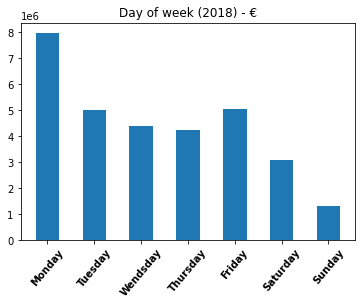

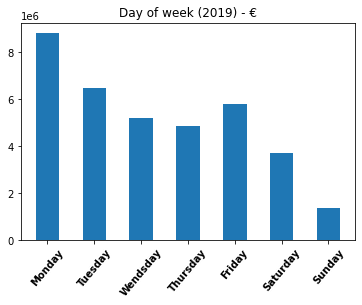

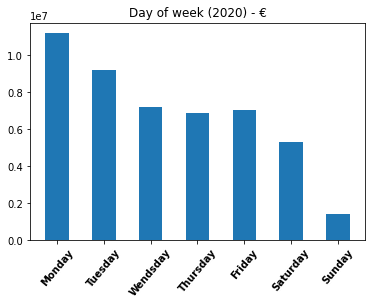

In [63]:
days_2018 = round(dataset[(dataset.ANO_FACTURA == 2018)].groupby(['DAY_OF_WEEK']).IMP_VENTA_NETO_EUR.sum(), 2)
days_2019 = round(dataset[(dataset.ANO_FACTURA == 2019)].groupby(['DAY_OF_WEEK']).IMP_VENTA_NETO_EUR.sum(), 2)
days_2020 = round(dataset[(dataset.ANO_FACTURA == 2020)].groupby(['DAY_OF_WEEK']).IMP_VENTA_NETO_EUR.sum(), 2)

d_name = {1: 'Monday', 2: 'Tuesday', 3: 'Wendsday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

def printagesales(df, name):
    plt.bar([1, 2, 3, 4, 5, 6, 7], df.Money, width=0.5)
    plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontweight='bold')
    plt.title(name)
    plt.xticks(rotation=50)
    plt.savefig('../Output/'+name+'.png')
    plt.show()

def prepareDayM(df):
    money = []
    for k, v in zip(df.index, df):
        money.append(v)
    dayprepared = pd.DataFrame({
        'Day_of_Week': range(1, 8),
        'Name_day_of_week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        'Money': money
    })
    return dayprepared

days_2018 = prepareDayM(days_2018)
days_2019 = prepareDayM(days_2019)
days_2020 = prepareDayM(days_2020)

printagesales(days_2018, 'Day of week (2018) - €')
printagesales(days_2019, 'Day of week (2019) - €')
printagesales(days_2020, 'Day of week (2020) - €')

In [71]:
month_days_2018 = round(dataset[(dataset.ANO_FACTURA == 2018)].groupby(['MES_FACTURA', 'DAY_OF_WEEK']).IMP_VENTA_NETO_EUR.sum(), 2)
month_days_2019 = round(dataset[(dataset.ANO_FACTURA == 2019)].groupby(['MES_FACTURA', 'DAY_OF_WEEK']).IMP_VENTA_NETO_EUR.sum(), 2)
month_days_2020 = round(dataset[(dataset.ANO_FACTURA == 2020)].groupby(['MES_FACTURA', 'DAY_OF_WEEK']).IMP_VENTA_NETO_EUR.sum(), 2)

d_name = {1: 'Monday', 2: 'Tuesday', 3: 'Wendsday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

def printagesales(df, name):
    plt.bar([1, 2, 3, 4, 5, 6, 7], df.Money, width=0.5)
    plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontweight='bold')
    plt.title(name)
    plt.xticks(rotation=50)
    plt.savefig('../Output/'+name+'.png')
    plt.show()

def prepareDayM(df):
    money = []
    month = []
    day = []
    for k, v in zip(df.index, df):
        money.append(v)
        month.append(k[0])
        day.append(k[1])
    daymprepared = pd.DataFrame({
        'Day_of_Week': day,
        'Month': month,
        'Money': money
    })
    return daymprepared

month_days_2018 = prepareDayM(month_days_2018)
month_days_2019 = prepareDayM(month_days_2019)
month_days_2020 = prepareDayM(month_days_2020)

Day_of_Week  Month      Money
0             1      1  898511.77
1             2      1  814851.73
2             3      1  720950.69
3             4      1  574989.24
4             5      1  692677.46
..          ...    ...        ...
79            3     12  361660.85
80            4     12  363936.37
81            5     12  501542.13
82            6     12  298878.76
83            7     12  154740.07

[84 rows x 3 columns]

## PCA

In [21]:
# como que lo que quiero es ver las variables que me interesan para el modelo, solo uso las ventas, el modelo tiene que predecir las ventas de un producto y una talla
pcadataset = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']
pcadataset = pcadataset.drop(columns=['FACTURA_ID', 'FACTURA_POSICION_ID', 'CUSTOMER_ID', 'FACTURA_CLASE_DOCUMENTO_ID', 'COLOR', 'CANAL_VENTA_ID', 'VENTA_DEVOLUCION'])
sdt = pcadataset.sort_values(['ANO_FACTURA', 'MES_FACTURA', 'FECHA_FACTURA'])
sdt.to_csv('info_data.csv', index = False, header=True) # Export raw data
display(sdt.shape)
print(pcadataset.shape)

In [22]:
# Encode 2-values labels
label_encoder = preprocessing.LabelEncoder()
pcadataset['CONTACTO_SN'].replace(to_replace= 'S', value = 1, inplace = True)
pcadataset['CONTACTO_SN'].replace(to_replace= 'N', value = 0, inplace = True)
pcadataset['EDAD_SN'].replace(to_replace= 'S', value = 1, inplace = True)
pcadataset['EDAD_SN'].replace(to_replace= 'N', value = 0, inplace = True)
pcadataset["GENERO_PRODUCTO"] = label_encoder.fit_transform(pcadataset[["GENERO_PRODUCTO"]])
pcadataset["GENERO_CONTACTO"] = label_encoder.fit_transform(pcadataset[["GENERO_CONTACTO"]])
pcadataset["TALLA"].replace(to_replace = 'NV', value = 0, inplace = True)
pcadataset["PRODUCTO_ID"] = label_encoder.fit_transform(pcadataset[["PRODUCTO_ID"]])
pcadataset["ESFUERZO_VENTA_ID"].replace(to_replace = 'NV', value = 0, inplace = True)
pcadataset["ESFUERZO_VENTA_ID"] = pcadataset["ESFUERZO_VENTA_ID"].astype(str)
pcadataset["ESFUERZO_VENTA_ID"] = label_encoder.fit_transform(pcadataset[["ESFUERZO_VENTA_ID"]])
pcadataset["JERARQUIA_PROD_ID"] = label_encoder.fit_transform(pcadataset[["JERARQUIA_PROD_ID"]])
pcadataset["CATEGORIA"] = label_encoder.fit_transform(pcadataset[["CATEGORIA"]])
pcadataset["TIPOLOGIA"] = label_encoder.fit_transform(pcadataset[["TIPOLOGIA"]])
pcadataset["CONSUMER_COLOR"] = label_encoder.fit_transform(pcadataset[["CONSUMER_COLOR"]])
pcadataset["CIUDAD_CONTACTO"] = label_encoder.fit_transform(pcadataset[["CIUDAD_CONTACTO"]])
pcadataset["IDIOMA_CONTACTO"] = label_encoder.fit_transform(pcadataset[["IDIOMA_CONTACTO"]])
pcadataset["CREMALLERA"] = label_encoder.fit_transform(pcadataset[["CREMALLERA"]])
pcadataset["CORDONES"] = label_encoder.fit_transform(pcadataset[["CORDONES"]])
pcadataset["OUTSOLE_SUELA_TIPO"] = label_encoder.fit_transform(pcadataset[["OUTSOLE_SUELA_TIPO"]])
pcadataset["OUTSOLE_SUELA_SUBTIPO"] = label_encoder.fit_transform(pcadataset[["OUTSOLE_SUELA_SUBTIPO"]])
pcadataset["PLANTILLA_EXTRAIBLE"] = label_encoder.fit_transform(pcadataset[["PLANTILLA_EXTRAIBLE"]])
pcadataset["NUMERO_DEUDOR_PAIS_ID"] = label_encoder.fit_transform(pcadataset[["NUMERO_DEUDOR_PAIS_ID"]])
pcadataset.to_csv('info_datav2.csv', index = False, header=True) # Export data labelled
pcadataset = pcadataset.drop(columns=['EDAD_RANGO_COMPRA', 'PRODUCTO_ID'])

In [32]:
normalizer = MinMaxScaler(feature_range = (-1, 1))
normalized = pd.DataFrame(normalizer.fit_transform(pcadataset), columns= pcadataset.columns)

In [33]:
pca = PCA()
principalComponents = pca.fit_transform(normalized)

In [34]:
print ('Proportion of Variance Explained : ', pca.explained_variance_ratio_)  
print('')
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ('Cumulative Prop. Variance Explained: ', out_sum)
print('')
print('Explained variance: ', pca.explained_variance_)

In [35]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = pcadataset.columns.values
loadings_df = loadings_df.set_index('variable')

In [36]:
ax = sns.heatmap(loadings_df, annot=False, cmap='Spectral', xticklabels=True, yticklabels=True)
plt.tick_params(axis='x', which='major', labelsize=4)
plt.tick_params(axis='y', which='major', labelsize=3)
plt.show()

In [37]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.show()

In [38]:
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), show= True)
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2))

In [39]:
colors = label_encoder.fit_transform(dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']["PRODUCTO_ID"])
plt.figure(figsize=(8,6))
plt.scatter(principalComponents[:,0], principalComponents[:,1],c=colors, cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.savefig('PCA.png')

In [40]:
colors = label_encoder.fit_transform(dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']["PRODUCTO_ID"])
#cluster.biplot(cscore=principalComponents, loadings=loadings, labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2),
#var2=round(pca.explained_variance_ratio_[1]*100, 2), show= True)
cluster.biplot(cscore=principalComponents, loadings=loadings, labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2),
var2=round(pca.explained_variance_ratio_[1]*100, 2), show= False)

In [42]:
numdeu = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON'][['NUMERO_DEUDOR_PAIS_ID', 'CIUDAD_CONTACTO']]